### Introduction
In this notebook we will write a simple algorithm to compute the persistent homology of a point cloud.
The basic idea of persistent homology is that given a set of points in an $n$ dimensional space, instead of analyzing the points directly, we can study the shape of the topological space of the union of $n$ dimensional spheres of radius $ɛ$ with center at the individual points. We can then calculate the Homology groups of this topological space to better understand its shape. We can also consider how the topological space changes when the radius ɛ of the spheres is changed. And thanks to persistent homology we are able to keep track of the features of the topological space as the radius grows.

It's really hard to compute directly the homology of the above described topological space. Luckily we can use an abstract simplicial complex representation of the space. This makes calculating the homology groups of the space much easier. We can represent our topological space using the Čech Complex generated by the point cloud. The Čech Complex will always be Homotopy equivalent to our space. In this notebook we will use a slightly different abstract simplicial complex called the Vietoris-Rips complex, as this is much easier to compute. In most cases the Vietoris-Rips Complex will have the same Homology groups as the Čech Complex.

The k-simplices of a Rips complex will be the simplices generated by k+1 points, such that the distance between any two of this points is at most $ɛ$.
Once we have computed the Rips complex we will then calculate the persistent homology of this complex. We will only consider the homology over the field $\mathbb{Z}_2$

In [21]:
import numpy as np
import matplotlib.pyplot as plt

We will use this simple 4 point data set to test our program as we go along.

In [22]:
ex_ds = np.array([[1,0], [0,1], [0,-1], [-1,0]])

Before creating the Rips complex of our point cloud, we will generate it's distance matrix(The matrix containing the distance between any two points), as this will come in handy later. We will only calculate the lower traiangul of the matrix as this is symetrical to it's upper counterpart.

In [23]:
#As our metric function we will use the standard euclidean distance
Euclidean = lambda a, b: np.linalg.norm(a-b)

# By defaultwe will assume we are using euclidian distance, but we can provide other distance functions if we want
def DistanceMatrix(ds, dist=Euclidean):
    dist_m = np.zeros([ds.shape[0],ds.shape[0]])
    for i in range(ds.shape[0]):
        for j in range(i):
            dist_m[i][j] = dist(ds[i], ds[j])
    return dist_m

In [24]:
dist_m = DistanceMatrix(ex_ds)
print(dist_m)

[[0.         0.         0.         0.        ]
 [1.41421356 0.         0.         0.        ]
 [1.41421356 2.         0.         0.        ]
 [2.         1.41421356 1.41421356 0.        ]]


We are now ready to calculate the Vietoris-Rips Complex of our data set. Recall that a simplex is part of the Vietoris-Rips complex if the distance between any two of it's vertices is at most $ɛ$. We will calculate the 0 and 1 simplices separately from the higher dimensional simplices as the algorithms are different.
We will represent each simplex as a list containing the Ids of each vertex in the simplex(always in ascending order). We will also calculate a list containing the minimum value $ɛ$ required for each simplex to exist(The maximum distance between any two points in the simplex), as this will be useful later on.

We will assign a number from 0 to n-1 to each vertex to represent its id. This Ids are arbitrary so we will use the index of a point in the dataset as its index.
The 0-skeleton will just be $[[0], [1], ..., [n-1]]$. The one skeleton will contain all pairs of verticies that are at most $ɛ$ distant from each other.

In [25]:
def RipsComplex0(ds):
    skeleton_0 = [[x] for x in range(ds.shape[0])]

    skeleton_0_dist = [0 for x in range(ds.shape[0])]

    return (skeleton_0, skeleton_0_dist)


def RipsComplex1(skeleton_0, skeleton_0_distances, dist_m, eps):
    skeleton_1 = []
    skeleton_1_dist = []

    #We loop throgh each point i and then through each point j such that j < i
    #And if p_i and p_j are at most epsilon appart we add the [j,i] simplex
    for i in range(len(skeleton_0)):
        for j in range(i):
            if (dist_m[i][j] <= eps):
                skeleton_1.append([j,i])
                skeleton_1_dist.append(dist_m[i][j])
    return (skeleton_1, skeleton_1_dist)

The higher dimensional n-simplices will be calculated inductively on the n-1 and n-2 simplices (Only the (n-1)-simplices are required, but using the (n-2)-simplices simplifies the algorithm). To find all the n-simplices we will loop through all the (n-2)-simplices. Lets represent one of them as $[x_1,...,x_n]$, we then select all (n-1)-simplices of the form $[x_1,...,x_n, y]$. For each pair of such simplices $[x_1,...,x_n, y]$ and $[x_1,...,x_n, z]$ we check if the distance between $y$ and $z$ is at most $ɛ$, and if so we add the new n-simplex $[x_1,...,x_n, y, z]$.

In [26]:
def RipsComplexN(ds, dist_m, eps, max_dim):
    rips_skeletons = [[] for i in range(max_dim)]
    rips_skeletons_dist = VRC_dist = [[] for i in range(max_dim)]

    #Calculate the 0 skeleton
    rips_skeletons[0], rips_skeletons_dist[0] = RipsComplex0(ds)

    #Calculate the 1 skeleton
    rips_skeletons[1], rips_skeletons_dist[1] = RipsComplex1(rips_skeletons[0], rips_skeletons_dist[0], dist_m, eps)


    #Calculate 2 and higher skeletons
    for dim in range(2,max_dim):
        #loop through dim-2 simplicies
        for n in range(len(rips_skeletons[dim-2])):
            # Select all (dim-1)simplicies that start with the same elements as the dim-2 simplex(and obviusly have an extra element)
            ind = [i for i in range(len(rips_skeletons[dim-1])) if rips_skeletons[dim-1][i][:-1] == rips_skeletons[dim-2][n]]

            # We have a dim-2 simplex rips_skeletons[dim-2][n] of the form: (x1, x2,..., x_dim-2)
            # We now loop through the dim-1 simplicies of the form (x1, x2,..., x_dim-2, y) and (x1, x2,..., x_dim-2, z)
            # And we create a new simplex (x1,...,x_dim-2, y, z) if y and z are at most epsilon appart.
            for i in range(len(ind)):
                for j in range(i):
                    y = rips_skeletons[dim-1][ind[j]][-1]
                    z = rips_skeletons[dim-1][ind[i]][-1]
                    dist_ij = dist_m[z][y]
                    if(dist_ij <= eps):
                        rips_skeletons[dim].append(rips_skeletons[dim-2][n] + [y] + [z])
                        #The minimum epsilon for the new skeleton will be the maximum of the two minimum epsilons of the previous skeletons and
                        #the distance between y and z
                        rips_skeletons_dist[dim].append(max(dist_ij, max(rips_skeletons_dist[dim-1][ind[i]], rips_skeletons_dist[dim-1][ind[j]])))

    #We will sort the simplicies in each n-skeleton based on their minimum epsilon
    #This will be necessary when calculating the persistent Homology
    for i in range(len(rips_skeletons)):
        vrc_sort = np.argsort(rips_skeletons_dist[i])
        rips_skeletons[i] = [rips_skeletons[i][j] for j in vrc_sort]
        rips_skeletons_dist[i] = [rips_skeletons_dist[i][j] for j in vrc_sort]

    #We combine all the skeletons into a single array.
    #We had an array [[0-simplicies], [1-simplices]...]
    #But we want [first_simplex, second_simplex, third_simplex ...]
    rips_complex = [S for C in rips_skeletons for S in C]
    rips_complex_dist = [S for C in rips_skeletons_dist for S in C]

    return (rips_complex, rips_complex_dist)

In [27]:
rips_complex, rips_complex_dist = RipsComplexN(ex_ds, dist_m, 10, 3)
print(rips_complex)
print(rips_complex_dist)

[[0], [1], [2], [3], [0, 1], [0, 2], [1, 3], [2, 3], [1, 2], [0, 3], [0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
[0, 0, 0, 0, 1.4142135623730951, 1.4142135623730951, 1.4142135623730951, 1.4142135623730951, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]



If we consider all the skeletons $C_n$ of our complex. We have a chain complex
$\\ 0 \rightarrow C_n → ... \rightarrow C_3 \rightarrow C_2 \rightarrow C_1 \rightarrow 0$
With the maps being the boundary maps $δ_n$, that map each simplex in $C_n$to it's boundaries in $C_{n-1}$. The Nth homology group $H_n = \frac{Ker(\delta_n)}{Img(δ_{n+1})}$. To find the kernel and image of each map, we can use their matrix representation. The matrix representation of $δ_n$ will be the matrix with the columns representing the simplicies of $C_n$ and each row representing the simplicies of $C_{n-1}$. The position $(i,j)$ of the matrix will be 1 if simplex $i$ has simplex $j$ in its boundary, and 0 otherwise.
To make the calculations easier we will combine all this matrices into a single square boundary matrix between all simplices. For simplicity we will often be working with the transpose of this matrix.

In [28]:
#This function returns the transpose of the boundery matrix
def BoundaryMatrix(C):
    num_of_simp = len(C)
    boundary_matrix_t = np.zeros([num_of_simp, num_of_simp])
    for s in range(num_of_simp):
        if(len(C[s]) > 1): # n-simplex must have n > 0(attleast 2 elements) to have a boundery
            bounderies = []
            for p in range(len(C[s])):
                bounderies.append(C.index(C[s][:p] + C[s][(p + 1):]))
            for b in bounderies:
                boundary_matrix_t[s][b] = 1
    return boundary_matrix_t

In [29]:
boundary_matrix_t = BoundaryMatrix(rips_complex)
print(boundary_matrix_t)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]]


We can calculate the Kernel and Image of each boundary map $δ_n$, by calculating the rank of its matrix representation. The kernel will be $\mathbb{Z}_2^{(dim-rank)}$ This makes intuitive topological sense as the kernel of the boundary map should represent the possible cycles in the complex, and we can think of each cycle as a linear combination of boundaries that equals to zero. The image of the maps will be $\mathbb{Z}_2^{rank}$. From a topological view point, this represents the boundaries of the higher dimensional simplicies. The boundaries of a simplex will always form a cycle, but we want to factor them out when calculating the homology as this cycles have been filled and therefore are not the boundaries of a hole.

We will use a variant of Gaussian elimination called column reduction on the boundary matrix to find this cycles.

For each column $i$ we will define $low(i)$ (also called pivot) as the highest index $j$ such that position $i,j$ in the boundary matrix is $1$. If column $i$ is all zeros we define $low(i) = -1$.
For each column $i$ such that $low(i) \not = -1$  we look if there are any columns $j$ to its left(i.e. $j < i$) such that $low(i) = low(j)$. For the left most such column, we will change column $i$ to the sum (mod 2) of columns $i$ and $j$ and repeat the process until $low(i) ≠ low(j)$ for any $j < i$.
Note that we are performing column reduction on the entire boundary matrix, but due to its geometry this is equivalent to performing the reduction on the individual matrix representations of each boundary map, and then combining them into a single matrix.

In [30]:
#Function to find the low of the ith column in the boundery matrix( using it's transpose)
def Low(i, boundary_matrix_t):
    j = i
    while (j >= 0):
        if (boundary_matrix_t[i][j] == 1):
            return j
        j -= 1
    return -1 #will use -1 to rapresent undefined low

#Note this function acts directly on the input boundery matrix
def MatrixColumnReduction(boundary_matrix_t):
    num_of_simp = boundary_matrix_t.shape[0]
    lows = [] # Array to keep track of the low of each column

    #Loop through each column
    for i in range(num_of_simp):
        j = 0
        #Loop through each column left of the current column
        while (j < len(lows)):
            #If the rows have the same low sum the two columns mod 2
            if (lows[j] == Low(i, boundary_matrix_t) and lows[j] != -1):
                boundary_matrix_t[i] = (boundary_matrix_t[i] + boundary_matrix_t[j])%2
                #The pivot of the current column will have changed so we have to restart looping from the first column.
                j = 0
            else:
                j += 1
        #Append the current column's low to the list of lows
        lows.append(Low(i, boundary_matrix_t))
    return lows

In [31]:
print("Boundery matrix before reduction: ")
print(boundary_matrix_t)
lows = MatrixColumnReduction(boundary_matrix_t)
print("Boundery matrix after reduction: ")
print(boundary_matrix_t)

Boundery matrix before reduction: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]]
Boundery matrix after reduction: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0

We can now extract the persistance pairs from the reduced boundary matrix. The all zero rows rappresent the birth of a feature with the introduction of that simplex. A row $i$ that isn't all zero will rapresent the death of a feature that was born with simplex $low(i)$ and is killed by simplex $i$.

Note that we have calculated only up to the 2-skeleton in this example. And therefore have a chain complex $C_2 \rightarrow C_1 \rightarrow C_0 \rightarrow 0$. We don't know what $C_3$ is, therefore we can't calculate $H_2$ as this woud require knowing the map $C_3 \rightarrow C_2$. If we wanted the calculate $H_2$ we should have also calculated $C_3$(This wouldn't make sense in our exapmle as we know our points are on a plane, but $C_3$ of the Rips complex wouldn't be trivial). The below algorithm solves the chain complex $\\ 0 \rightarrow C_2 \rightarrow C_1 \rightarrow C_0 \rightarrow 0$ but it's result might be incorrect for $H_2$ as we don't actually know that $C_3$ is trivial. Threfore we will drop this result.

In [32]:
#The inputs are: The Simplicial Complex, it's minimum epsilon list, thelist of lows, the max distance, the maximum dimension.
#We don't have the boundary matrix as a parameter because all the neccesary information is in the list of its lows.
def Homology(C, C_dist, lows, MAX, max_dim):
    H = [{} for i in range(max_dim)]
    for i in range(len(lows)):
        dim = len(C[i])-1
        if (lows[i] == -1):  # All zero row
            H[dim][i] = [C_dist[i], MAX+1] #We intially assume new borns never die
        elif(H[dim-1][lows[i]][1] == MAX+1):# This should always be true
            if(H[dim-1][lows[i]][0] == C_dist[i]):
                #This rapresents a node that is born and dies at the same epsilon
                #This happens when we introduce the boundery of a simplex and imidiatly after the simplex it self.
                #We will remove this pairs.
                H[dim-1].pop(lows[i])
            else:
                H[dim-1][lows[i]] = [H[dim-1][lows[i]][0], C_dist[i]]
        else:
            Exception("Invalid reduced boundery matrix")

    #Droping the persistance pairs for the last homology group as they might be incorrect.
    H.pop(-1)

    return H

In [33]:
H = Homology(rips_complex, rips_complex_dist, lows, dist_m.max(), 3)
H

[{0: [0, 3.0],
  1: [0, 1.4142135623730951],
  2: [0, 1.4142135623730951],
  3: [0, 1.4142135623730951]},
 {7: [1.4142135623730951, 2.0]}]

In [34]:
#Simple function to plot our results
def PHPlots(H, MAX):
    plt.figure(figsize=(4,4))
    for n in range(len(H)):
        x = [i[1] for i in H[n].values()]
        y = [i[0] for i in H[n].values()]
        plt.scatter(y,x, alpha=0.3, label="{}-Homology".format(n))
        plt.axis([-0.5,MAX+0.5,-0.5,MAX+0.5])
    plt.legend(loc='lower right')
    plt.plot(np.linspace(-0.5,MAX+0.5,10),np.linspace(-0.5,MAX+0.5,10), color='r')
    plt.xlabel("Birth")
    plt.ylabel("Death")
    plt.title("Persistent Homoloy")
    plt.show()

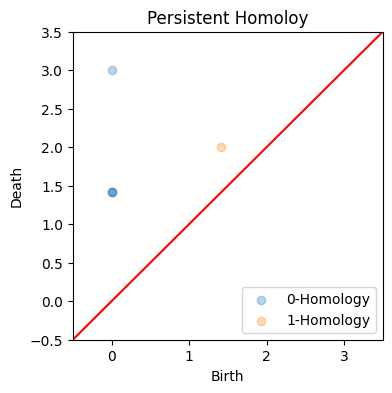

In [35]:
PHPlots(H, dist_m.max()+1)
#Note that some points are darker: this represents overlapping pairs.

We can combine all the steps we have seen into a single function.

In [36]:
def PersistentHomology(ds, dist=Euclidean, max_eps=None, max_dim=3):

    #Compute the distance matrix of the data set
    dist_m = DistanceMatrix(ds, dist)

    MAX = dist_m.max()

    #If the epsilon wasn't specified we will just use an arbitrarly large epsilon
    #We could have chosen the smallest enclosing radius of our points as epsilon
    #As this is enough to guarante that all Homology groups are trivial.
    if(max_eps is None):
        max_eps = MAX

    #Compute the rips complex of the data set
    rips_complex, rips_complex_dist = RipsComplexN(ds, dist_m, max_eps, max_dim)

    #Compute the boundary matrix
    bound_matrix = BoundaryMatrix(rips_complex)

    #Perform column reduction on the boundary matrix
    lows = MatrixColumnReduction(bound_matrix)

    #Exctract the perstence pars from the reduced boundery matrix
    H = Homology(rips_complex, rips_complex_dist, lows, MAX, max_dim)

    return H

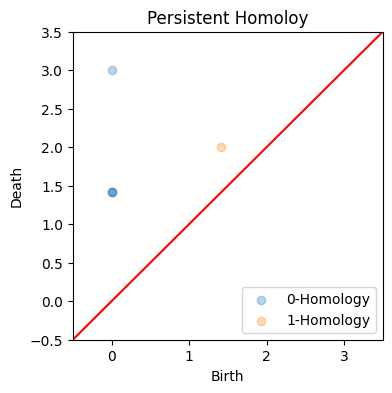

In [37]:
data = np.array([[1,0], [0,1], [0,-1], [-1,0]])
H = PersistentHomology(data)
PHPlots(H, 3)

We can also try a slightly more complex data set:



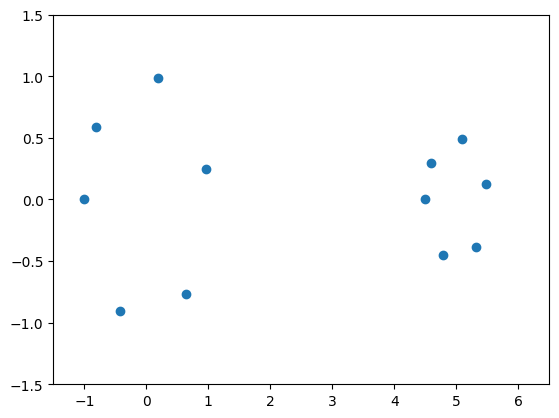

In [38]:
phi = np.array([np.pi*x for x in np.linspace(-1,0.8,6)])

data1 = np.array([[np.cos(d), np.sin(d)] for d in phi]+[[np.cos(d)*0.5+5, np.sin(d)*0.5] for d in phi]) #points on a circle

plt.scatter(data1[:,0] , data1[:,1])
plt.axis([-1.5, 6.5,-1.5,1.5])
plt.show()

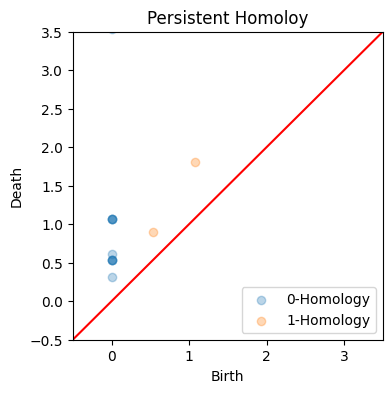

In [39]:
H1 = PersistentHomology(data1)
PHPlots(H1, 3)

Obviously this implementation is too slow for any real usage. Many things can be done to calculate the persistence homology faster. Such as not using Python but a faster programming languages like C++ or Rust. Using a better implementation of the algorithm, like using a sparse matrices, and Hash Tables. And using faster algorithm like row reduction with a twist or using persistent Cohomology.